In [1]:
# -*- coding: utf-8 -*-
import sys
import pandas as pd
import numpy as np
import glob
import os
automl_path = "../../oboe/automl"
sys.path.append(automl_path)
import convex_opt
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib.lines as mlines
from tqdm import tqdm
%matplotlib inline

data preparation:

In [2]:
df_runtime = pd.read_csv("{}/defaults/runtime_matrix.csv".format(automl_path), index_col=0, header=0)
df_sizes = pd.read_csv("{}/defaults/dataset_sizes.csv".format(automl_path), index_col=0, header=0)

try:
    df_runtime.drop(1043, inplace=True)
except:
    pass
try:
    df_runtime.drop(1176, inplace=True)
except:
    pass

runtimes_original = df_runtime.values
runtimes_index_original = np.array(df_runtime.index)


runtimes = df_runtime.values
runtimes_index = np.array(df_runtime.index)
sizes = df_sizes.values
sizes_index = np.array(df_sizes.index)
degree = 3

leave-one-out cross validation of time prediction on midsize OpenML datasets (150 < n < 10,000)

In [3]:
degree = 3 # degree of the runtime predictor polynomials
predictor = convex_opt.RuntimePredictor(degree, sizes, sizes_index, np.log2(runtimes), runtimes_index)

sizes = df_sizes.values
sizes_index = np.array(df_sizes.index)
runtimes_predicted_multiple = []

for i,idx in tqdm(enumerate(runtimes_index)):
    df_runtime_tmp = df_runtime.drop(idx)
    runtimes = df_runtime_tmp.values
    runtimes_index_training = np.array(df_runtime_tmp.index)

    predictor = convex_opt.RuntimePredictor(degree, sizes, sizes_index, np.log2(runtimes), runtimes_index_training)

    runtimes_predicted_single = predictor.predict(sizes[list(sizes_index).index(idx), :])
    runtimes_predicted_multiple.append(runtimes_predicted_single)

runtimes_predicted_multiple = np.array(runtimes_predicted_multiple)
#     pd.DataFrame(runtimes_predicted_multiple, index=None, columns=None).to_csv('runtime_cv.csv', index=None, header=None)

418it [00:58,  7.19it/s]


collect data in Table 2, model-wise accuracy:

In [4]:
algorithms = [eval(df_runtime.columns[i])['algorithm'] for i in range(df_runtime.shape[1])]
columns = []
accuracy_2 = []
accuracy_4 = []
for alg in np.unique(algorithms):
    columns = [i for i in range(df_runtime.shape[1]) if eval(df_runtime.columns[i])['algorithm']==alg]
    accuracy_2.append(np.sum(abs(runtimes_predicted_multiple[:, columns] - np.log2(runtimes_original[:, columns]))<=1)/(runtimes_original[:, columns].shape[0] * runtimes_original[:, columns].shape[1]))
    accuracy_4.append(np.sum(abs(runtimes_predicted_multiple[:, columns] - np.log2(runtimes_original[:, columns]))<=2)/(runtimes_original[:, columns].shape[0] * runtimes_original[:, columns].shape[1]))
    
accuracy_2 = np.array(accuracy_2)
accuracy_4 = np.array(accuracy_4)

In [5]:
models = df_runtime.columns

num_hyperparameter_settings = [-1]
for i in range(len(models) - 1):
    if eval(models[i+1])['algorithm'] != eval(models[i])['algorithm']:
        num_hyperparameter_settings.append(i)
num_hyperparameter_settings.append(len(models) - 1)
num_hyperparameter_settings = np.diff(np.array(num_hyperparameter_settings))

color_list = ['red', 'green', 'blue', 'cyan', 'salmon', 'purple', 'khaki', 'rust', 'orange', 'sepia', 'heather', 'brown', 'maize']
color_list = ['xkcd:{}'.format(i) for i in color_list]

cumsum_hyperparameter_settings = np.cumsum(num_hyperparameter_settings)
cumsum_hyperparameter_settings = np.concatenate((np.array([0]), cumsum_hyperparameter_settings))

def alg_index(i):
    return np.sum(i - cumsum_hyperparameter_settings > -1) - 1

algorithm_names = ['Adaboost', 'Decision Tree', 'Extra Trees', 'Gradient Boosting', 'Gaussian Naive Bayes', 'kNN', 'Logistic Regression', 'Multilayer Perceptron', 'Perceptron', 'Random Forest', 'Kernel SVM', 'Linear SVM']

Figure 7, modelwise runtime prediction performance:

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


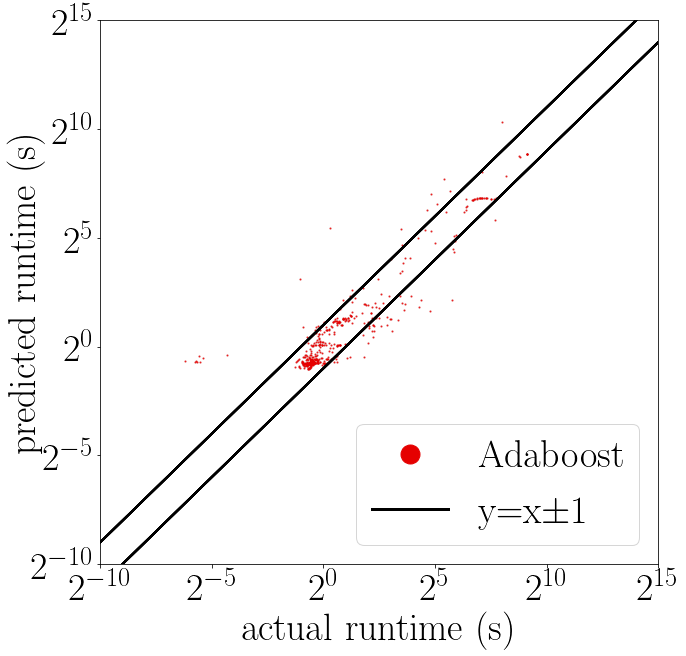

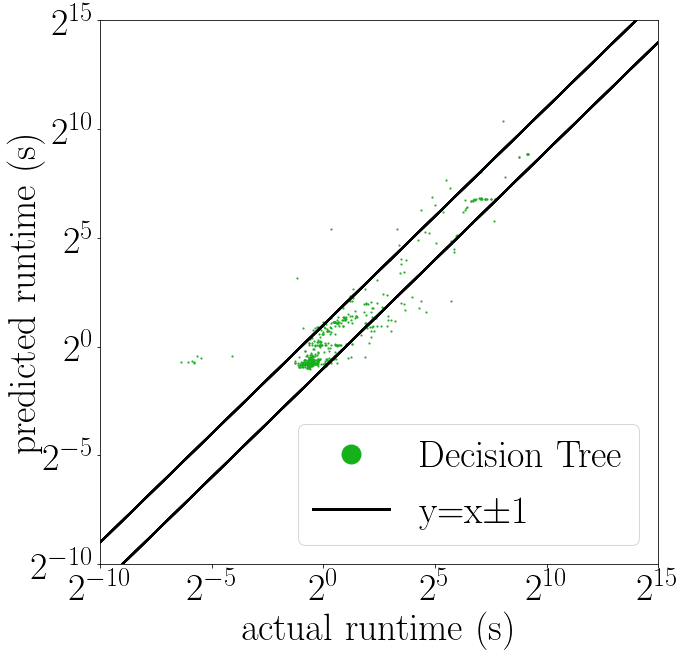

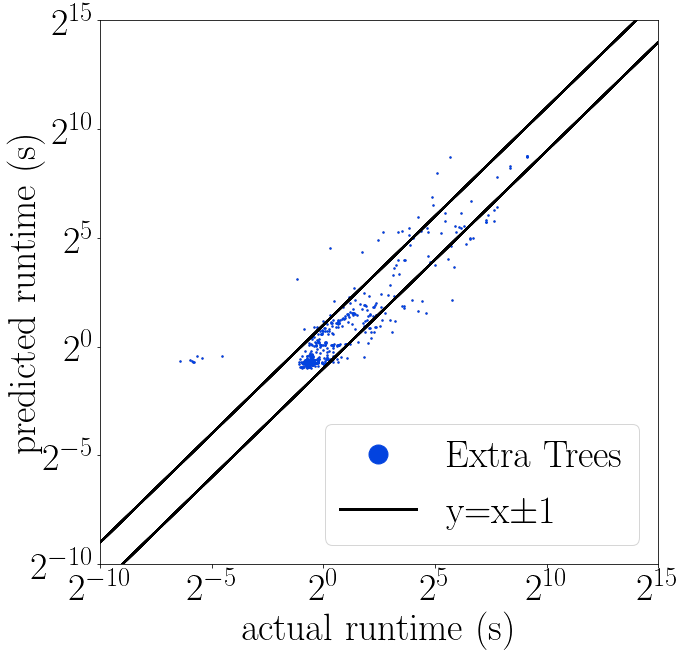

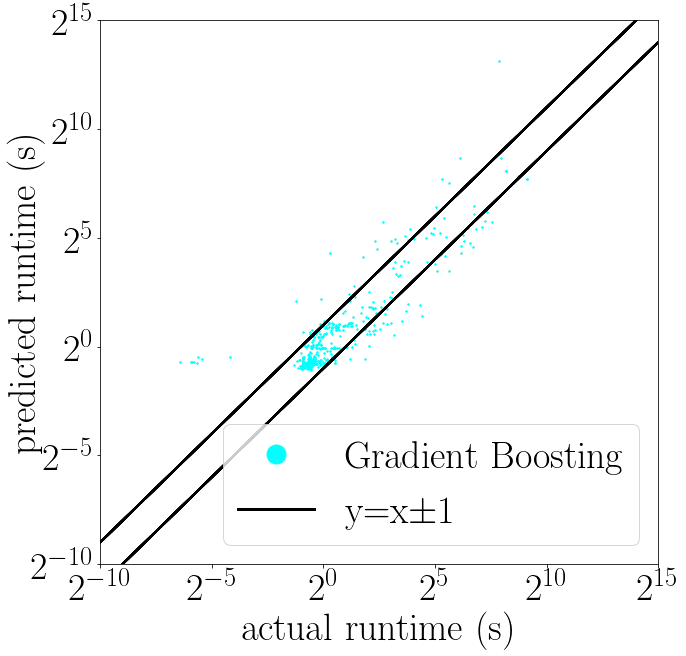

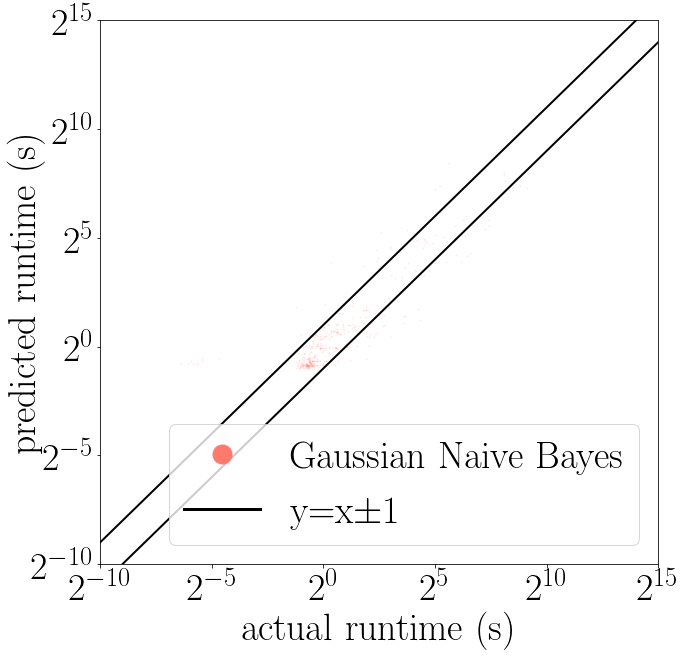

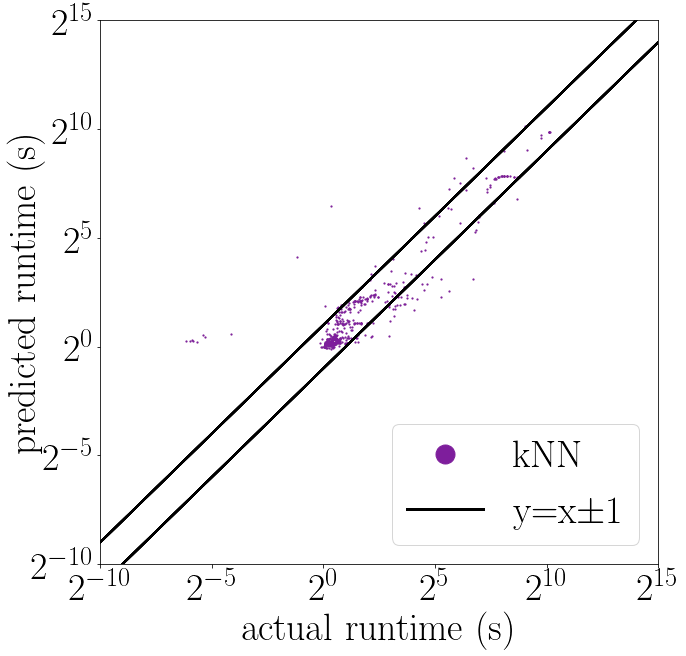

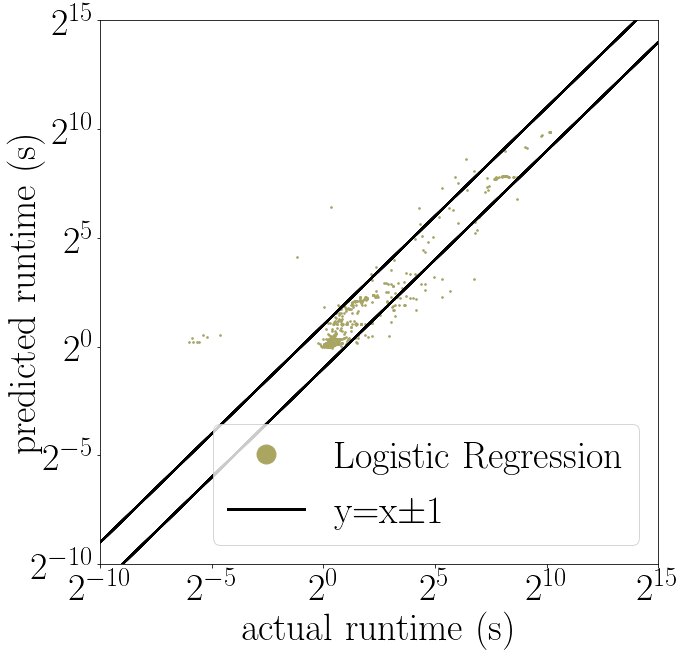

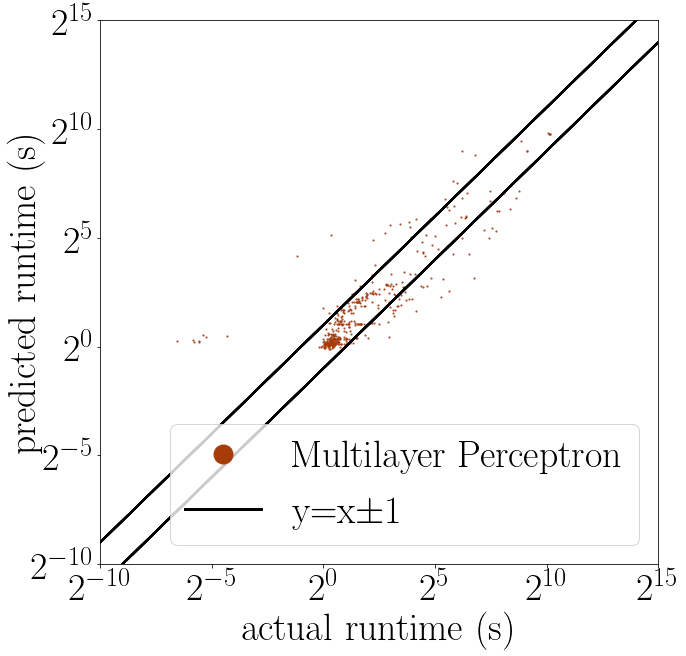

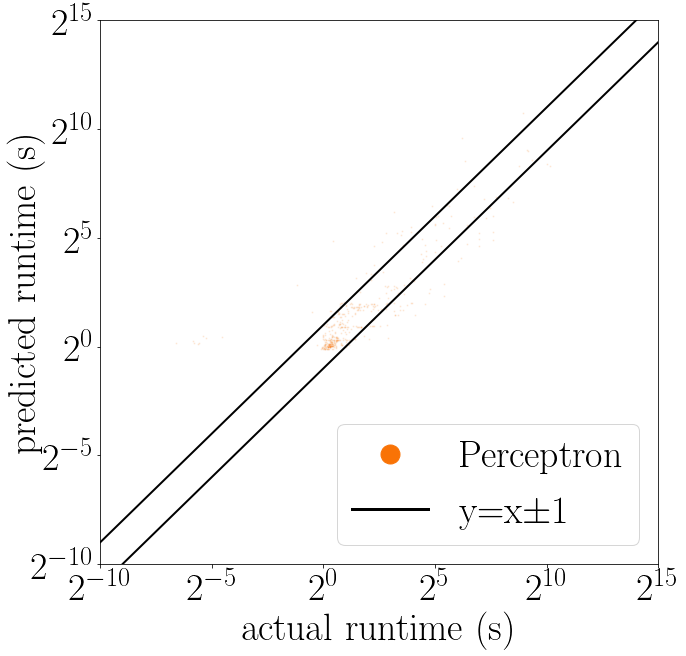

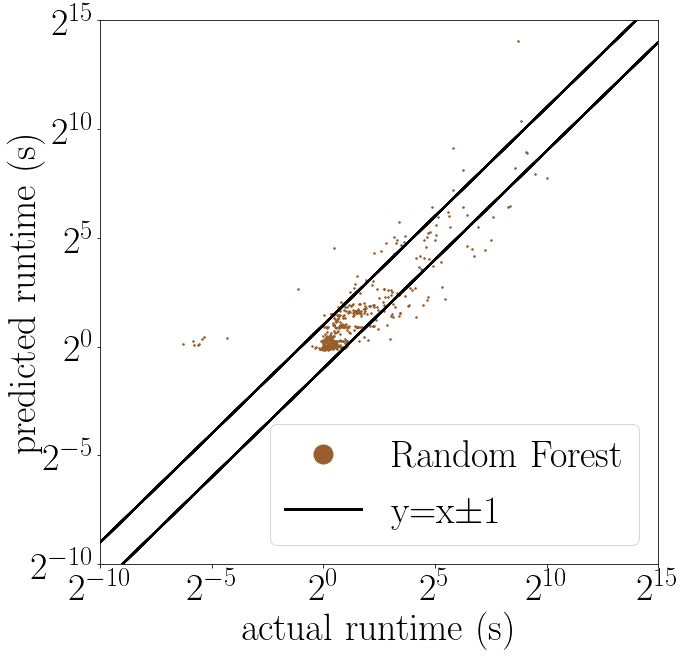

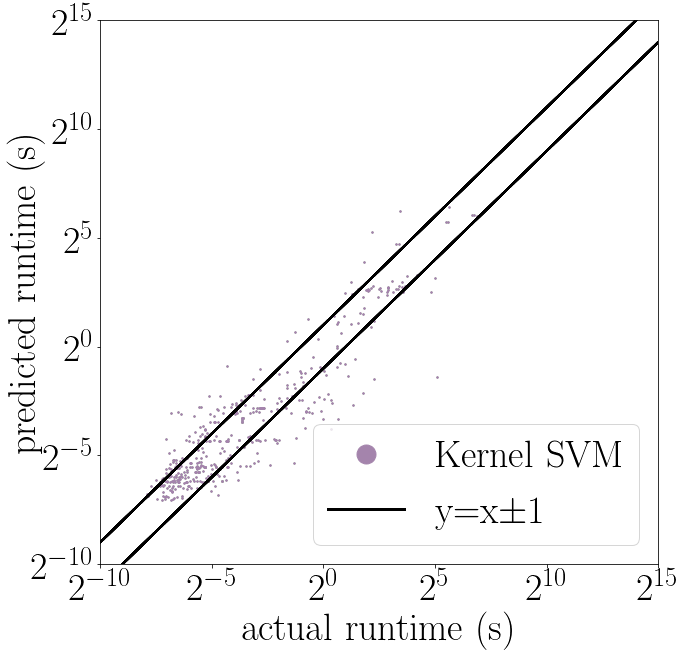

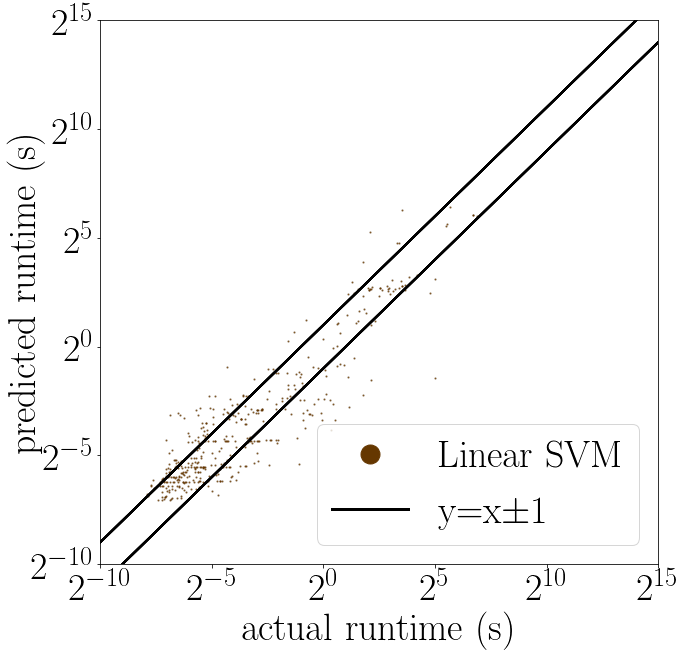

In [6]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 22, 'weight': 'bold'})
rc('text', usetex=True)

#save algorithm-wise plots into multiple images
lower = -10
upper = 15
alpha = 0.1
fontsize_axes = 38
legend_marker_size = 38

n_algorithms = len(cumsum_hyperparameter_settings) - 1


for i in range(n_algorithms):
    algorithm_name = eval(models[cumsum_hyperparameter_settings[i]])['algorithm']
    fig, ax = plt.subplots(figsize=(10, 10))
    color = color_list[i]
    for model in range(cumsum_hyperparameter_settings[i], cumsum_hyperparameter_settings[i+1]):
        markers = []
        
        ax.scatter(np.log2(runtimes_original)[:, i], runtimes_predicted_multiple[:, i], s=1, alpha=0.1, color=color)
        markers.append(mlines.Line2D([], [], color=color_list[i], marker='.', linestyle='None', markersize=legend_marker_size, label=algorithm_names[i]))

        ax.plot([lower, upper], [lower+1, upper+1], color='black', linewidth=2, label='y=x+1')
        ax.plot([lower, upper], [lower-1, upper-1], color='black', linewidth=2, label='y=x-1')
        markers.append(mlines.Line2D([lower, upper], [lower+1, upper+1], color='black', linewidth=3, label='y=x$\pm$1'))
        ax.set_xlabel('actual runtime (s)', fontsize=fontsize_axes)
        ax.set_ylabel('predicted runtime (s)', fontsize=fontsize_axes, labelpad=-14)

        ax.set_xlim([lower, upper])
        ax.set_ylim([lower, upper])
        
        # ax.legend(loc='lower right', fontsize=18, markerscale=5, marker=".")
        ax.legend(loc='lower right', fontsize=legend_marker_size, handles=markers)
#         ax.grid()
        ax.set_xticklabels(['$2^{-10}$', '$2^{-5}$', '$2^{0}$', '$2^{5}$', '$2^{10}$', '$2^{15}$'], fontsize=fontsize_axes)
        ax.set_yticklabels(['$2^{-10}$', '$2^{-5}$', '$2^{0}$', '$2^{5}$', '$2^{10}$', '$2^{15}$'], fontsize=fontsize_axes)
#     plt.grid()
#     plt.savefig('runtime_prediction_{}.pdf'.format(algorithm_name))
#     plt.savefig('runtime_prediction_{}.png'.format(algorithm_name), dpi = 200, bbox_inches='tight')
        

plt.show()

overlap of runtime prediction performance of different models in Figure 7:

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


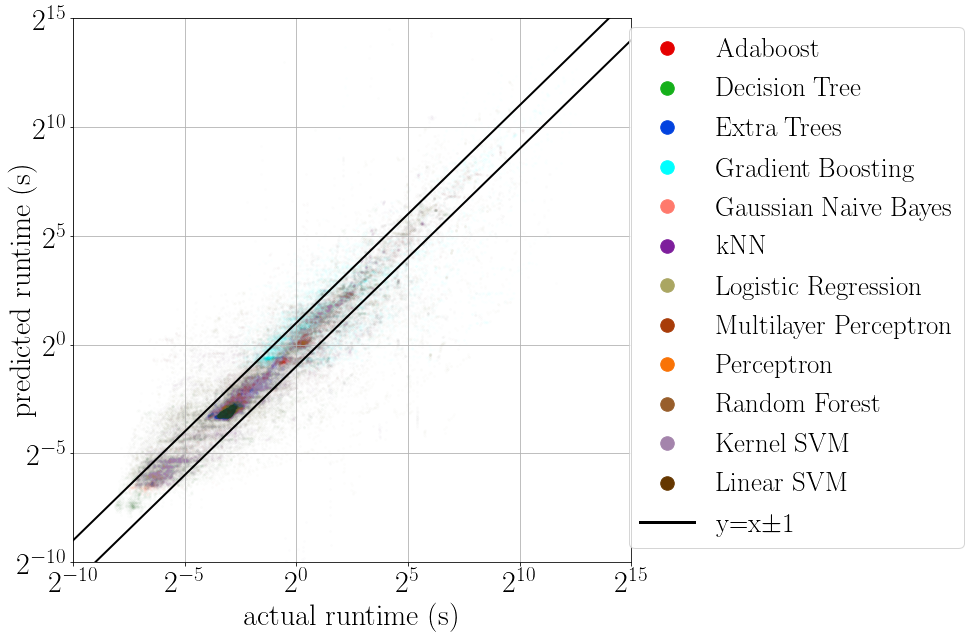

In [7]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 22, 'weight': 'bold'})
rc('text', usetex=True)

#all models mixed together

lower = -10
upper = 15
alpha = 0.007
fontsize_axes = 30
legend_marker_size = 27


cmap = [color_list[alg_index(i)] for i in range(len(models))]
fig, ax = plt.subplots(figsize=(10, 10))
markers = []
for i in range(len(models)):
    ax.scatter(np.log2(runtimes_original)[:, i], runtimes_predicted_multiple[:, i], s=3, alpha=alpha, color=color_list[alg_index(i)])
    if i in cumsum_hyperparameter_settings:
        markers.append(mlines.Line2D([], [], color=color_list[alg_index(i)], marker='.', linestyle='None', markersize=legend_marker_size, label=algorithm_names[alg_index(i)]))

        
ax.plot([lower, upper], [lower+1, upper+1], color='black', linewidth=2, label='y=x+1')
ax.plot([lower, upper], [lower-1, upper-1], color='black', linewidth=2, label='y=x-1')
markers.append(mlines.Line2D([lower, upper], [lower+1, upper+1], color='black', linewidth=3, label='y=x$\pm$1'))
ax.set_xlabel('actual runtime (s)', fontsize=fontsize_axes)
ax.set_ylabel('predicted runtime (s)', fontsize=fontsize_axes, labelpad=-20)

ax.set_xlim([lower, upper])
ax.set_ylim([lower, upper])
ax.grid()

ticklabels = ['$2^{-10}$', '$2^{-5}$', '$2^{0}$', '$2^{5}$', '$2^{10}$', '$2^{15}$']
ax.set_xticklabels(ticklabels, fontsize=fontsize_axes, weight=1000)
ax.set_yticklabels(ticklabels, fontsize=fontsize_axes)

ax.legend(loc='lower right', bbox_to_anchor=(1.62, 0), fontsize=legend_marker_size, handles=markers)

# plt.savefig('runtime_prediction_all.png', dpi = 250, bbox_inches='tight')
plt.show()